In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.stats import rankdata


In [2]:
#class that defines a city
#Has a constructor function, and calculates and stores the distance between two cities
class City:
    
    def __init__(self,x,y):
        self.x = x
        self.y = y
    
    def __repr__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ")"
    
    def distance(self, city2):
        xDist = self.x - city2.x
        yDist = self.y - city2.y
        distance = np.sqrt((xDist ** 2) + (yDist ** 2))
        return distance

In [3]:
#another definition for distance whcih is not part of a class but can be called for two classes as arguments
def distance(city1, city2):
    xDist = city1.x - city2.x
    yDist = city1.y - city2.y
    distance = np.sqrt((xDist ** 2) + (yDist ** 2))
    return distance

In [4]:
#a class that is used to generate different possible routes between the cities randomly and also calculated the 
#total distance and total fitness of that particular route as an inverse of the distance (since we need to 
#maximise the function(fitness) and minimize the distance hence)
class Route:
    
 
    
    def __init__(self):
        self.route = []
        self.distance = 0
        self.fitness = 0
        
    
    def CreateRoute(self,cities):
        self.route = random.sample(cities, len(cities))
    
    
    
    def RouteDistance(self):
        self.distance = 0
        for i in range(len(self.route) - 1):
            city1 = self.route[i]
            if((i + 1) >= len(self.route)):
                city2 = self.route[0]
            else:
                city2 = self.route[i + 1]
            self.distance += city1.distance(city2)

    
    def RouteFitness(self):
        
        self.fitness = 1 / float(self.distance)
    
        
    def __repr__(self):
        return (str(self.route)) 
    
    
        
        

In [5]:
#this class holds different possible routes in a population
#performs selection, crossover, mutation and elitism to give a new generation of population

#two different methods for selection have been implemented in this, roulette wheel based selection 
#and rank based selection
#rank based selection was chosen ultimately because of better performance however
#the other method has been commented out for reference

#three different mutation methods were tried and the best one according to results has been used

#elitism is the process by which we carry forward the best chromosomes to the next generation. this depends
#on the elitesize chosen which is usually 20-25% of the initial population


class Population:
    
    def __init__(self, cities, populationSize, eliteSize, mutationRate):
        
        self.population = []
        self.popSize = populationSize
        self.eliteSize = eliteSize
        self.mutationRate = mutationRate
        
        for i in range(self.popSize):
            r = Route()
            r.CreateRoute(cities)
            self.population.append(r)
            self.population[i].RouteDistance()
            self.population[i].RouteFitness()
        
    
    def FittestSorted(self):
        
        self.population.sort(key = lambda x: x.fitness, reverse = True)
        
       
    #this is the selection based method based on roulette wheel selection
    
#     def Selection(self):
        
#         self.FittestSorted()
#         self.selectedPool = []
        
#         #based on elitesize, add them to the selection pool
#         for i in range(self.eliteSize):
#             self.selectedPool.append(self.population[i])
            
        
#         #roulette wheel selection
#         dataframe = pd.DataFrame(columns=['Route','Distance','Fitness'])
#         for i in range(self.popSize):
#             dataframe.loc[i] = [self.population[i].route,self.population[i].distance, self.population[i].fitness]
        
#         dataframe['Fitness'] = dataframe['Fitness'] / dataframe['Fitness'].sum()
#         dataframe['cumulative'] = dataframe['Fitness'].cumsum()
      
        
#         for i in range(self.popSize - self.eliteSize):
#             r = random.random()
#             for index in range(self.popSize):
#                 if(r >= dataframe.iat[index,3]):
#                     self.selectedPool.append(self.population[index])
#                     break
        
    
    #selection based on rank based algorithm
    def Selection(self):
        
        self.FittestSorted()
        self.selectedPool = []
        
        #based on elitesize, add them to the selection pool
        for i in range(self.eliteSize):
            self.selectedPool.append(self.population[i])
            
        
        
        dataframe = pd.DataFrame(columns=['Route','Distance','Fitness'])
        for i in range(self.popSize):
            dataframe.loc[i] = [self.population[i].route,self.population[i].distance, self.population[i].fitness]
        
        dataframe['Rank'] = rankdata(dataframe['Fitness'], method = 'min')
        dataframe['Rank'] = dataframe['Rank'] / dataframe['Rank'].sum()
        dataframe['cumulative'] = dataframe['Rank'].cumsum()
      
        
        for i in range(self.popSize - self.eliteSize):
            r = random.random()
            for index in range(self.popSize):
                if(r >= dataframe.iat[index,4]):
                    self.selectedPool.append(self.population[index])
                    break
        
            
        
    
    def Breed(self, parent1, parent2):
        
        gene1 = random.randrange(0, len(parent1.route), 1)
        gene2 = random.randrange(0, len(parent2.route), 1)
        
        child1 = []
        child2 = []
        child = Route()
        
        start = min(gene1, gene2)
        end = max(gene1, gene2)
        
        child1 = parent1.route[start:end + 1]
        child2 = [city for city in parent2.route if city not in child1]
        child.route = child1 + child2
        child.RouteDistance()
        child.RouteFitness()
        return child
        
    
    def Crossover(self):
        
        self.children = []
        
        breedingPool = random.sample(self.selectedPool, len(self.selectedPool))
        breedLength = self.popSize - self.eliteSize
        
        self.children = self.selectedPool[:self.eliteSize]
        
        for i in range(breedLength):
            
            child = self.Breed(breedingPool[i], breedingPool[len(breedingPool) - i - 2])
            self.children.append(child)
    
   
    
    def Mutate(self):
        
        for i in range(len(self.children)):
            
            if (random.random() > self.mutationRate):
        
                gene1 = random.randrange(0, len(self.children[i].route), 1)
                gene2 = random.randrange(0, len(self.children[i].route), 1)
                
                
                
# Method 1 of mutation (Centre Inverse Mutation):                
#                 self.children[i].route[:gene1] = self.children[i].route[:gene1][::-1]
#                 self.children[i].route[gene1:] = self.children[i].route[gene1:][::-1]

                start = min(gene1, gene2)
                end = max(gene1, gene2)

# Method 2 of mutation (Reverse Sequence Mutation) (showed the best experimental results):

                self.children[i].route[gene1:gene2] = self.children[i].route[gene1:gene2][::-1]

# Method 3 of mutation (swapping of genes):
#                 temp = self.children[i].route[gene1]
#                 self.children[i].route[gene1] = self.children[i].route[gene2]
#                 self.children[i].route[gene2] = temp

            self.children[i].RouteDistance()
            self.children[i].RouteFitness()
        
    def NextGeneration(self):
        
        self.population = self.children
        #just to be sure, calculate route distances and fitness values again
        for i in range(self.popSize):
            self.population[i].RouteDistance()
            self.population[i].RouteFitness()
        self.children = []
        
        
    def GetFittestCity(self):
        self.population.sort(key = lambda x: x.fitness, reverse = True)
        return self.population[0].distance
        
        
        

(20833.3333, 17100.0)
(20900.0, 17066.6667)
(21300.0, 13016.6667)
(21600.0, 14150.0)
(21600.0, 14966.6667)
(21600.0, 16500.0)
(22183.3333, 13133.3333)
(22583.3333, 14300.0)
(22683.3333, 12716.6667)
(23616.6667, 15866.6667)
(23700.0, 15933.3333)
(23883.3333, 14533.3333)
(24166.6667, 13250.0)
(25149.1667, 12365.8333)
(26133.3333, 14500.0)
(26150.0, 10550.0)
(26283.3333, 12766.6667)
(26433.3333, 13433.3333)
(26550.0, 13850.0)
(26733.3333, 11683.3333)
(27026.1111, 13051.9444)
(27096.1111, 13415.8333)
(27153.6111, 13203.3333)
(27166.6667, 9833.3333)
(27233.3333, 10450.0)
(27233.3333, 11783.3333)
(27266.6667, 10383.3333)
(27433.3333, 12400.0)
(27462.5, 12992.2222)
Fittest city in iteration : 0 is: 71075.81399569557
Fittest city in iteration : 1 is: 64822.58268907769
Fittest city in iteration : 2 is: 59777.02331683178
Fittest city in iteration : 3 is: 59594.8625119536
Fittest city in iteration : 4 is: 58149.67653862069
Fittest city in iteration : 5 is: 54436.47798141404
Fittest city in iterat

Fittest city in iteration : 142 is: 25720.25597483737
Fittest city in iteration : 143 is: 25720.25597483737
Fittest city in iteration : 144 is: 25720.25597483737
Fittest city in iteration : 145 is: 25720.25597483737
Fittest city in iteration : 146 is: 25720.25597483737
Fittest city in iteration : 147 is: 25720.25597483737
Fittest city in iteration : 148 is: 25720.25597483737
Fittest city in iteration : 149 is: 25720.25597483737
Fittest city in iteration : 150 is: 25720.25597483737
Fittest city in iteration : 151 is: 25720.25597483737
Fittest city in iteration : 152 is: 25720.25597483737
Fittest city in iteration : 153 is: 25720.25597483737
Fittest city in iteration : 154 is: 25720.25597483737
Fittest city in iteration : 155 is: 25720.25597483737
Fittest city in iteration : 156 is: 25720.25597483737
Fittest city in iteration : 157 is: 25720.25597483737
Fittest city in iteration : 158 is: 25720.25597483737
Fittest city in iteration : 159 is: 25720.25597483737
Fittest city in iteration : 

Fittest city in iteration : 295 is: 24901.353569124378
Fittest city in iteration : 296 is: 24901.353569124378
Fittest city in iteration : 297 is: 24901.353569124378
Fittest city in iteration : 298 is: 24901.353569124378
Fittest city in iteration : 299 is: 24901.353569124378
Fittest city in iteration : 300 is: 24901.353569124378
Fittest city in iteration : 301 is: 24901.353569124378
Fittest city in iteration : 302 is: 24901.353569124378
Fittest city in iteration : 303 is: 24901.353569124378
Fittest city in iteration : 304 is: 24901.353569124378
Fittest city in iteration : 305 is: 24901.353569124378
Fittest city in iteration : 306 is: 24901.353569124378
Fittest city in iteration : 307 is: 24901.353569124378
Fittest city in iteration : 308 is: 24901.353569124378
Fittest city in iteration : 309 is: 24901.353569124378
Fittest city in iteration : 310 is: 24901.353569124378
Fittest city in iteration : 311 is: 24901.353569124378
Fittest city in iteration : 312 is: 24901.353569124378
Fittest ci

Fittest city in iteration : 444 is: 24849.139220464353
Fittest city in iteration : 445 is: 24849.139220464353
Fittest city in iteration : 446 is: 24849.139220464353
Fittest city in iteration : 447 is: 24849.139220464353
Fittest city in iteration : 448 is: 24849.139220464353
Fittest city in iteration : 449 is: 24849.139220464353
Fittest city in iteration : 450 is: 24849.139220464353
Fittest city in iteration : 451 is: 24849.139220464353
Fittest city in iteration : 452 is: 24849.139220464353
Fittest city in iteration : 453 is: 24849.139220464353
Fittest city in iteration : 454 is: 24849.139220464353
Fittest city in iteration : 455 is: 24849.139220464353
Fittest city in iteration : 456 is: 24849.139220464353
Fittest city in iteration : 457 is: 24849.139220464353
Fittest city in iteration : 458 is: 24849.139220464353
Fittest city in iteration : 459 is: 24849.139220464353
Fittest city in iteration : 460 is: 24849.139220464353
Fittest city in iteration : 461 is: 24849.139220464353
Fittest ci

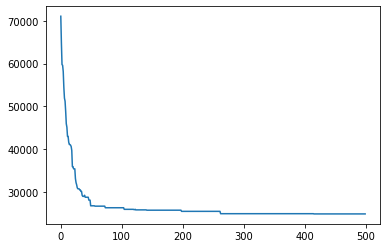

In [6]:

#running the GA

#Randomly generate values for city
# cityList = []
# for i in range(20):
#     cityList.append(City(x = int(random.random() * 100), y = int(random.random() *100)))

cityList = []
data = pd.read_csv("test4-27603.csv", header = None)
data.head()
for i in range(data.shape[0]):
    r = data[0][i].split()
    cityList.append(City(float(r[0]),float(r[1])))

for i in range(len(cityList)):
    print(cityList[i])
    
populationSize = 100
eliteSize = 20
mutationRate = 0.02

pop = Population(cityList, populationSize, eliteSize, mutationRate)


iterations = 500
progress = []

for i in range(iterations):
    
    
    pop.Selection()
    pop.Crossover()
    pop.Mutate()
    pop.NextGeneration()
    
    
    print("Fittest city in iteration : " + str(i) + " is: " + str(pop.GetFittestCity()))
    progress.append(pop.GetFittestCity())

print(pop.population[0])
plt.plot(np.arange(iterations), progress)

plt.show()    